<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -V

Python 3.7.12


In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
from pytz import timezone
from tqdm.notebook import tqdm

%matplotlib inline

### COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19/blob/development/FORKED_SITES.md

In [3]:
urls = {
    'tokyo': 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json',
#     'saitama': 'https://raw.githubusercontent.com/codefortoda/covid19-saitama/development/data/data.json',
    'aichi': 'https://raw.githubusercontent.com/code4nagoya/covid19/development/data/data.json',
#     'osaka': 'https://raw.githubusercontent.com/codeforosaka/covid19/development/data/data.json',
    'hyogo': 'https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json',
    'fukui': 'https://raw.githubusercontent.com/nomunomu0504/covid19/nomu_development/data/patients_summary.json',
    # 'tottori': 'https://raw.githubusercontent.com/tottori-covid19/covid19/master/data/data.json',
    'shimane': 'https://raw.githubusercontent.com/TaigaMikami/shimane-covid19/shimane/data/patients_summary.json',
    'okinawa': 'https://raw.githubusercontent.com/Code-for-OKINAWA/covid19/development/data/data.json',
    'fukuoka': 'https://raw.githubusercontent.com/Code-for-Fukuoka/covid19-fukuoka/development/data/data.json',
    # 'hokkaido': 'https://stopcovid19.hokkaido.dev/api/patients_summary.json',
    'hokkaido': 'https://codeforsapporo.github.io/covid19hokkaido_scraping/patients_summary.json',
#     'kanagawa': 'https://www.pref.kanagawa.jp/osirase/1369/data/data.json',
    ##'chiba': 'https://raw.githubusercontent.com/civictechzenchiba/covid19-chiba/development/data/data.json',
    #'hiroshima': 'https://raw.githubusercontent.com/tatsuya1970/covid19/development/data/data.json',
    'fukushima': 'https://cdn2.dott.dev/data.json',
#     'chiba': 'https://covid19chiba.s3-ap-northeast-1.amazonaws.com/DataPub.json',
    'shizuokashi': 'https://db7rdtcq3byow.cloudfront.net/data.json',
    'hamamatsushi': 'https://raw.githubusercontent.com/code-for-hamamatsu/covid19/dev-hamamatsu/data/hamamatsu/data.json',
    'shiga': 'https://shiga-pref-org.github.io/covid19-data/data.json',
}

In [4]:
def get_json_data(pref: str, url: str) -> dict:
    response = requests.get(url)
    json_data = json.loads(response.text)
    
    # json文字列をdictへ
    if pref == 'shimane':
        return json_data['patients_summary']
    if pref == 'hokkaido':
        return {'data': [{'日付': j['日付'], '小計': j['日陽性数']} for j in json_data['data']]}
    if pref == 'kanagawa':
        print(json_data['patient'])
#     print(json_data['patients_summary']['data'])
    return json_data

In [5]:
#res = get_json_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [6]:
def datetime_to_date(datestr: str) -> datetime:
    return datetime.datetime.strptime(re.sub(r'T.*$', '', datestr), '%Y-%m-%d')

In [7]:
def utc_datestr_to_jst_date(datestr: str) -> datetime:
   return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  #return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [8]:
#utc_datestr_to_jst_date('2020-08-12T12:34:56.789Z')

In [9]:
def get_patients_count(json_data: dict, file_name: str) -> list:
    if file_name == 'data.json':
        return [data['小計'] for data in json_data['patients_summary']['data']]
    return [data['小計'] for data in json_data['data']]

In [10]:
def get_df_index(json_data: dict, file_name: str):
    if file_name == 'data.json':
        return [datetime_to_date(d['日付']) for d in json_data['patients_summary']['data']]
#         return pd.date_range(
#             start=datetime_to_date(json_data['patients_summary']['data'][0]['日付']),
#             end=datetime_to_date(json_data['patients_summary']['data'][-1]['日付']),
#             freq='D')
    return [datetime_to_date(d['日付']) for d in json_data['data']]
#     return pd.date_range(
#             start=datetime_to_date(json_data['data'][0]['日付']),
#             end=datetime_to_date(json_data['data'][-1]['日付']),
#             freq='D')

In [11]:
def get_data(pref: str, url: str):
    json_data = get_json_data(pref, url)
#     print(json_data)
    file_name = url.split('/')[-1]

    # 日毎の数
    patients_count = get_patients_count(json_data, file_name)
    # dataframe index
    df_index = get_df_index(json_data, file_name)

    # データフレームにセット（インデックスに日付をセット）
    df = pd.DataFrame({'patients_count': patients_count}, index=df_index)
    # 7日間移動平均・合計カラムを追加
    try:
        df['7d_mov_ave'] = df['patients_count'].rolling('7D').mean()
        df['7d_mov_sum'] = df['patients_count'].rolling('7D').sum()
    except Exception as e:
        print(e)
        df['7d_mov_ave'] = np.zeros(len(df['patients_count']))
        df['7d_mov_sum'] = np.zeros(len(df['patients_count']))
        
    return df

In [12]:
# url = urls['tottori']
# print(url)
# res = get_data(url)
# print(type(res))
# print(res.tail(15))

In [13]:
for k, v in tqdm(urls.items()):
    print(k, v)
    res = get_data(k, v)
    #res = get_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
    #res = get_data('https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json')
    print(type(res))
    print(res.tail(15))
    print('-----')

  0%|          | 0/12 [00:00<?, ?it/s]

tokyo https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json
<class 'pandas.core.frame.DataFrame'>
            patients_count  7d_mov_ave  7d_mov_sum
2021-11-08              18   21.428571       150.0
2021-11-09              30   23.142857       162.0
2021-11-10              25   23.142857       162.0
2021-11-11              31   25.571429       179.0
2021-11-12              22   25.142857       176.0
2021-11-13              24   24.428571       171.0
2021-11-14              22   24.571429       172.0
2021-11-15               7   23.000000       161.0
2021-11-16              15   20.857143       146.0
2021-11-17              27   21.142857       148.0
2021-11-18              20   19.571429       137.0
2021-11-19              16   18.714286       131.0
2021-11-20              16   17.571429       123.0
2021-11-21              20   17.285714       121.0
2021-11-22               6   17.142857       120.0
-----
aichi https://raw.githubusercontent.com/co

In [14]:
def week_num(d: datetime) -> str:
    return f'\'{d.strftime("%y")}w{d.strftime("%V")}'

In [15]:
def week_num_list(l: list) -> list:
    return [week_num(d) for d in l]

In [16]:
def week_day(d: datetime) -> str:
    return d.strftime('%a')

In [17]:
def week_day_list(l: list) -> list:
    return [week_day(d) for d in l]

In [18]:
# res = pd.DataFrame({
#     'week_num': week_num_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)]),
#     'week_day': week_day_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)])
# })
# print(type(res))
# res

In [19]:
def get_df(pref: str, url: str):
    df = get_data(pref, url)
    # 日付カラムを追加
    df['datetime'] = df.index
    # 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
    df['week_num'] = week_num_list(df.index)
    # 曜日の列をセット
    df['week_day'] = week_day_list(df.index)
    return df

In [20]:
#res = get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [21]:
def agg_df(df):
    # 週毎に集計
    groupby_week_num = df.groupby('week_num')
    # 集計結果から平均と合計を取得しデータフレームにセット
    return pd.DataFrame({
        'week_num': df['week_num'].unique(),
        'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
        'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
    }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])

In [22]:
# res = agg_df(get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'))
# print(type(res))
# res

In [23]:
dfs = {}
weekly_agg_dfs = {}
for k, v in tqdm(urls.items()):
    df = get_df(k, v)
    weekly_agg_df = agg_df(df)
    # 集計カラムを追加
    df = pd.concat([
        df, weekly_agg_df.loc[:, ['week_mean', 'week_sum']]
    ], axis=1)
    dfs[k] = df
#     weekly_agg_dfs[item[0]] = weekly_agg_df

#print(min([len(v) for k, v in dfs.items()]))
#print(weekly_agg_dfs)

  0%|          | 0/12 [00:00<?, ?it/s]

In [24]:
pd.DataFrame({k: dfs[k]['patients_count'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-11-08,18,NaN,5.0,NaN,NaN,NaN,NaN,6.0,0.0,0.0,NaN,NaN
2021-11-09,30,NaN,15.0,NaN,NaN,NaN,NaN,13.0,1.0,3.0,NaN,NaN
2021-11-10,25,NaN,15.0,NaN,NaN,NaN,NaN,8.0,0.0,0.0,NaN,NaN
2021-11-11,31,NaN,3.0,NaN,NaN,NaN,NaN,8.0,0.0,0.0,NaN,NaN
2021-11-12,22,NaN,10.0,NaN,NaN,NaN,NaN,22.0,0.0,0.0,NaN,NaN
2021-11-13,24,NaN,15.0,NaN,NaN,NaN,NaN,19.0,0.0,0.0,NaN,NaN
2021-11-14,22,NaN,6.0,NaN,NaN,NaN,NaN,9.0,0.0,0.0,NaN,NaN
2021-11-15,7,NaN,3.0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,NaN,NaN
2021-11-16,15,NaN,12.0,NaN,NaN,NaN,NaN,35.0,0.0,0.0,NaN,NaN
2021-11-17,27,NaN,5.0,NaN,NaN,NaN,NaN,40.0,0.0,0.0,NaN,NaN


In [25]:
pd.DataFrame({k: dfs[k]['7d_mov_ave'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-11-08,21.428571,NaN,13.285714,NaN,NaN,NaN,NaN,10.428571,0.285714,0.571429,NaN,NaN
2021-11-09,23.142857,NaN,13.857143,NaN,NaN,NaN,NaN,10.285714,0.428571,0.714286,NaN,NaN
2021-11-10,23.142857,NaN,12.428571,NaN,NaN,NaN,NaN,9.571429,0.285714,0.714286,NaN,NaN
2021-11-11,25.571429,NaN,11.428571,NaN,NaN,NaN,NaN,10.142857,0.285714,0.714286,NaN,NaN
2021-11-12,25.142857,NaN,10.428571,NaN,NaN,NaN,NaN,11.428571,0.285714,0.714286,NaN,NaN
2021-11-13,24.428571,NaN,9.285714,NaN,NaN,NaN,NaN,12.285714,0.285714,0.571429,NaN,NaN
2021-11-14,24.571429,NaN,9.857143,NaN,NaN,NaN,NaN,12.142857,0.142857,0.428571,NaN,NaN
2021-11-15,23.000000,NaN,9.571429,NaN,NaN,NaN,NaN,11.714286,0.142857,0.428571,NaN,NaN
2021-11-16,20.857143,NaN,9.142857,NaN,NaN,NaN,NaN,14.857143,0.000000,0.000000,NaN,NaN
2021-11-17,21.142857,NaN,7.714286,NaN,NaN,NaN,NaN,19.428571,0.000000,0.000000,NaN,NaN


In [26]:
pd.DataFrame({k: dfs[k]['7d_mov_sum'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-11-08,150.0,NaN,93.0,NaN,NaN,NaN,NaN,73.0,2.0,4.0,NaN,NaN
2021-11-09,162.0,NaN,97.0,NaN,NaN,NaN,NaN,72.0,3.0,5.0,NaN,NaN
2021-11-10,162.0,NaN,87.0,NaN,NaN,NaN,NaN,67.0,2.0,5.0,NaN,NaN
2021-11-11,179.0,NaN,80.0,NaN,NaN,NaN,NaN,71.0,2.0,5.0,NaN,NaN
2021-11-12,176.0,NaN,73.0,NaN,NaN,NaN,NaN,80.0,2.0,5.0,NaN,NaN
2021-11-13,171.0,NaN,65.0,NaN,NaN,NaN,NaN,86.0,2.0,4.0,NaN,NaN
2021-11-14,172.0,NaN,69.0,NaN,NaN,NaN,NaN,85.0,1.0,3.0,NaN,NaN
2021-11-15,161.0,NaN,67.0,NaN,NaN,NaN,NaN,82.0,1.0,3.0,NaN,NaN
2021-11-16,146.0,NaN,64.0,NaN,NaN,NaN,NaN,104.0,0.0,0.0,NaN,NaN
2021-11-17,148.0,NaN,54.0,NaN,NaN,NaN,NaN,136.0,0.0,0.0,NaN,NaN


In [27]:
for k, v in tqdm(dfs.items()):
    print(k)
    print(v[['week_day', 'patients_count', '7d_mov_ave', '7d_mov_sum']].tail(15))
    print('---')

  0%|          | 0/12 [00:00<?, ?it/s]

tokyo
           week_day  patients_count  7d_mov_ave  7d_mov_sum
2021-11-08      Mon              18   21.428571       150.0
2021-11-09      Tue              30   23.142857       162.0
2021-11-10      Wed              25   23.142857       162.0
2021-11-11      Thu              31   25.571429       179.0
2021-11-12      Fri              22   25.142857       176.0
2021-11-13      Sat              24   24.428571       171.0
2021-11-14      Sun              22   24.571429       172.0
2021-11-15      Mon               7   23.000000       161.0
2021-11-16      Tue              15   20.857143       146.0
2021-11-17      Wed              27   21.142857       148.0
2021-11-18      Thu              20   19.571429       137.0
2021-11-19      Fri              16   18.714286       131.0
2021-11-20      Sat              16   17.571429       123.0
2021-11-21      Sun              20   17.285714       121.0
2021-11-22      Mon               6   17.142857       120.0
---
aichi
           week_day  pat

In [28]:
titles = ['daily count', '7days mean', '7days sum']
x = list(dfs.items())[0][1].index

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

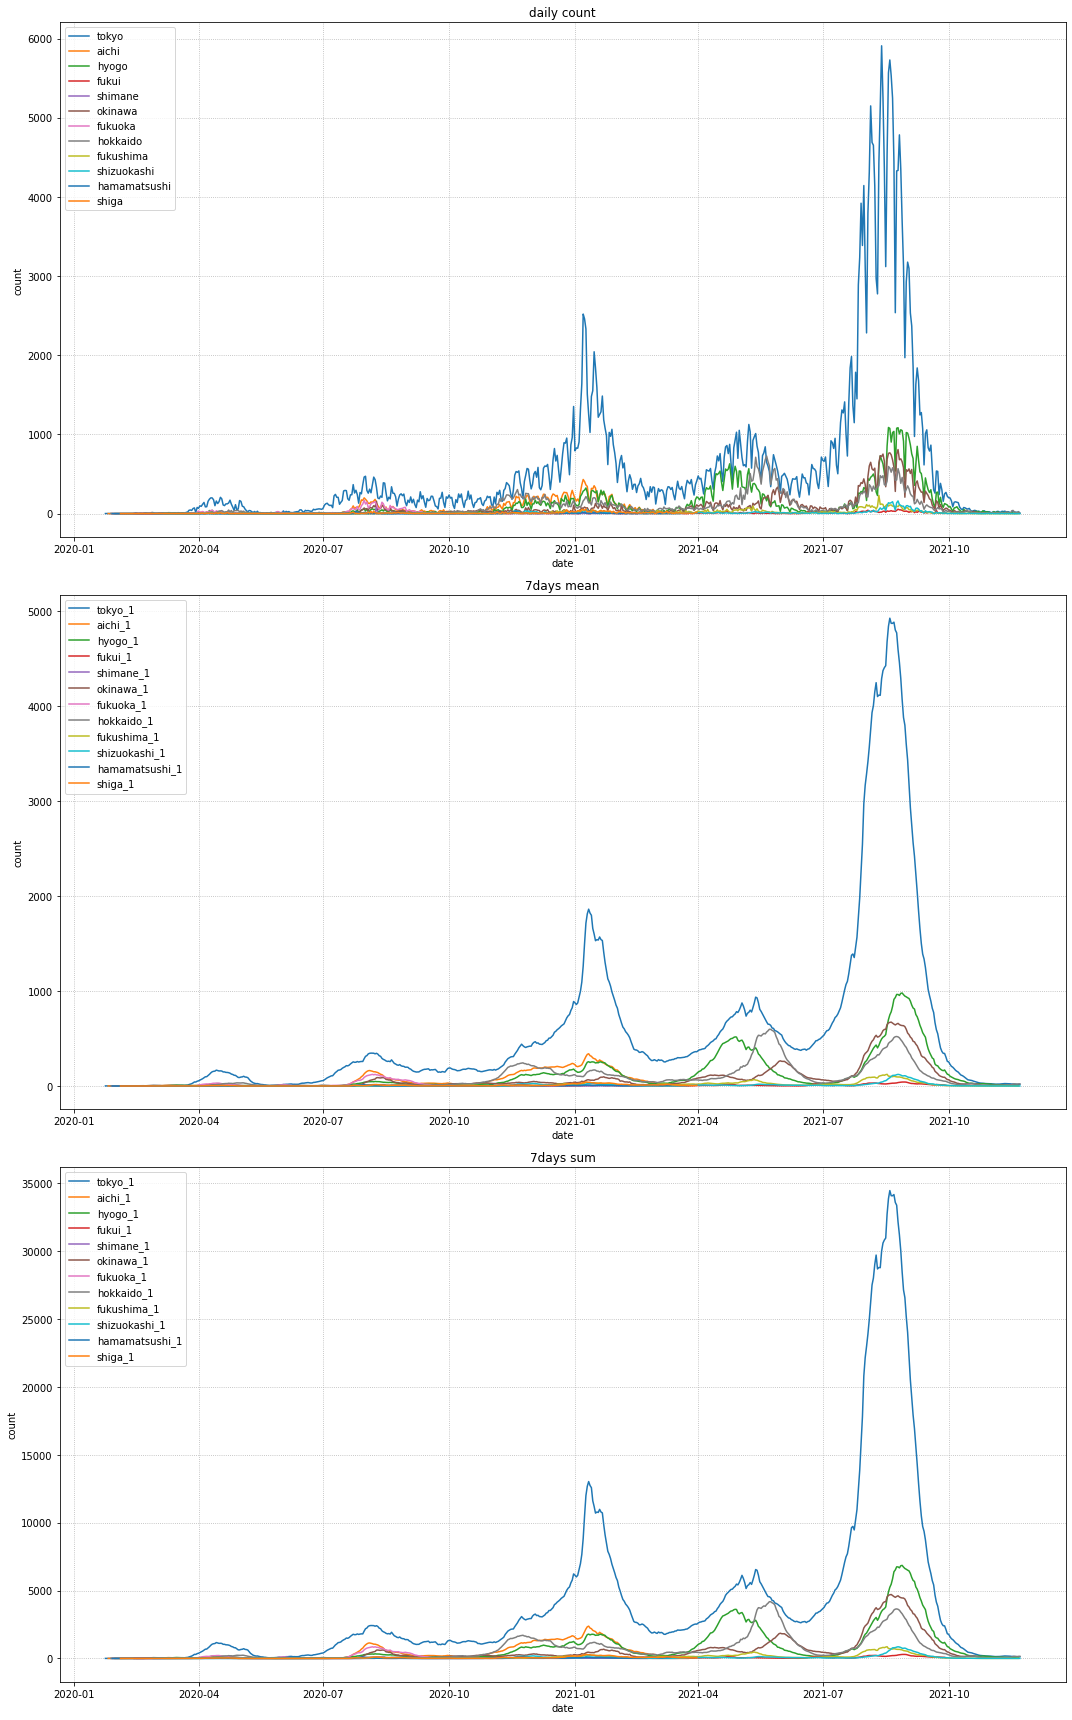

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

for k, v in tqdm(dfs.items()):
    x = v.index
    y1 = v['patients_count']
    ax[0].plot(x, y1, label=k)
    
    y2_1 = v['7d_mov_ave']
    ax[1].plot(x, y2_1, label=f"{k}_1")
    # y2_2 = v['week_mean']
    # ax[1].bar(x, y2_2, label=f"{k}_2")
    
    y3_1 = v['7d_mov_sum']
    ax[2].plot(x, y3_1, label=f"{k}_1")
    # y3_2 = v['week_sum']
    # ax[2].bar(x, y3_2, label=f"{k}_2")

for i, _ax in tqdm(enumerate(ax)):
    _ax.set_title(titles[i])
    _ax.set_xlabel('date')
    _ax.set_ylabel('count')
    _ax.grid(linestyle=':')
    _ax.legend(loc='upper left')

plt.tight_layout()

In [30]:
dfs.keys()

dict_keys(['tokyo', 'aichi', 'hyogo', 'fukui', 'shimane', 'okinawa', 'fukuoka', 'hokkaido', 'fukushima', 'shizuokashi', 'hamamatsushi', 'shiga'])

In [31]:
dfs2 = dfs.copy()
del dfs2['tokyo']
dfs2.keys()

dict_keys(['aichi', 'hyogo', 'fukui', 'shimane', 'okinawa', 'fukuoka', 'hokkaido', 'fukushima', 'shizuokashi', 'hamamatsushi', 'shiga'])

In [32]:
x = list(dfs.items())[0][1].index

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

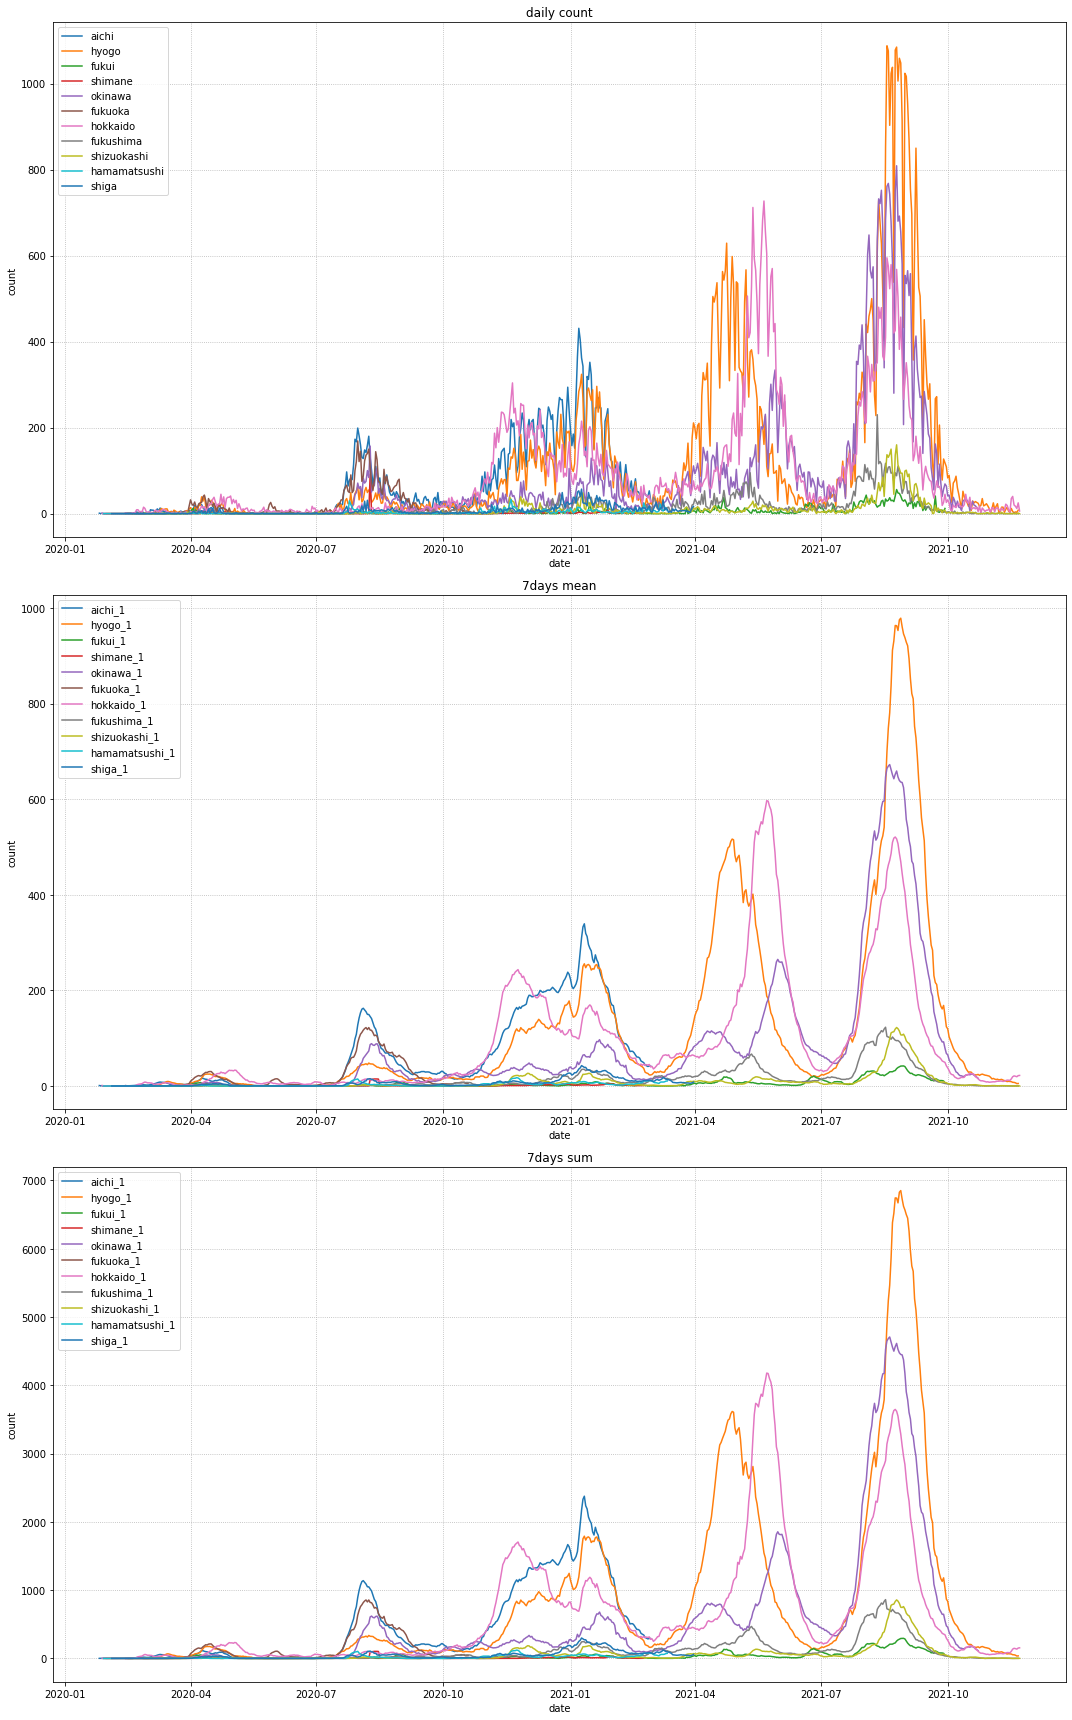

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

for k, v in tqdm(dfs2.items()):
    x = v.index
    y1 = v['patients_count']
    ax[0].plot(x, y1, label=k)
    
    y2_1 = v['7d_mov_ave']
    ax[1].plot(x, y2_1, label=f"{k}_1")
    # y2_2 = v['week_mean']
    # ax[1].bar(x, y2_2, label=f"{k}_2")
    
    y3_1 = v['7d_mov_sum']
    ax[2].plot(x, y3_1, label=f"{k}_1")
    # y3_2 = v['week_sum']
    # ax[2].bar(x, y3_2, label=f"{k}_2")

for i, _ax in tqdm(enumerate(ax)):
    _ax.set_title(titles[i])
    _ax.set_xlabel('date')
    _ax.set_ylabel('count')
    _ax.grid(linestyle=':')
    _ax.legend(loc='upper left')

plt.tight_layout()